In [1]:
%load_ext watermark

## Data dependencies

In [2]:
mfcc_df_path = "../data/CXH2_GY.w2v.parquet"
!sha1sum $mfcc_df_path

53afcbbae6cbf63b8b2d4c81fecd44e8dda1f9d6  ../data/CXH2_GY.w2v.parquet


## Load data

In [3]:
import pandas as pd
df = pd.read_parquet(mfcc_df_path)

In [4]:
df.head()

filename  idx    start_t      end_t pinyin char phone  type  \
0  CXH2_GY    2  10.666971  10.873312    zi4    自     z  nasp   
1  CXH2_GY    5  11.472899  11.660520  gang1    剛     g  nasp   
2  CXH2_GY    6  11.660520  11.847044   kai1    開     k   asp   
3  CXH2_GY   11  12.591354  12.788113    de0    得     d  nasp   
4  CXH2_GY   19  14.939134  15.014852    de0    得     d  nasp   

                                           w2v_first  \
0  [-0.039923646, 0.17577721, 0.010047715, -0.024...   
1  [-0.032513373, 0.20862468, 0.0021272004, -0.01...   
2  [-0.034185313, 0.20750004, 0.002972044, -0.016...   
3  [-0.03147293, 0.21054856, 0.002919186, -0.0146...   
4  [-0.03248522, 0.21022739, 0.0014499277, -0.013...   

                                            w2v_mean  
0  [-0.033518482, 0.20856047, 0.0032428657, -0.01...  
1  [-0.03210089, 0.21084635, 0.0015181245, -0.013...  
2  [-0.03185012, 0.21322665, 0.0019027384, -0.014...  
3  [-0.031839296, 0.21316287, 0.0030109058, -0.01...  
4  [-0.0331649, 0.21051401, 0.0015671713, -0.0141...

In [5]:
import numpy as np
from sklearn.manifold import TSNE
import plotly_express as px

phone_labels = df.phone
asp_labels = df.type
w2v_first = np.vstack(df.w2v_first.to_numpy())
w2v_mean = np.vstack(df.w2v_mean.to_numpy())
SEED = 122

## First frame W2V

In [6]:
tsne = TSNE()
proj = tsne.fit_transform(w2v_first)

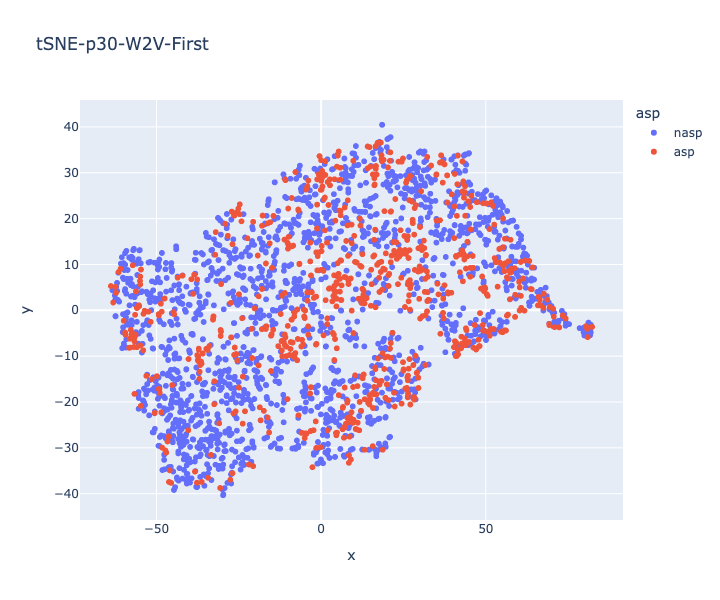

In [7]:
plot_df = pd.DataFrame({"x": proj[:,0], "y": proj[:,1], 
                        "phone": phone_labels,
                        "asp": asp_labels})
fig = px.scatter(plot_df, "x", "y", color="asp", 
                 title="tSNE-p30-W2V-First",
                 hover_data=["phone"])
fig.update_layout(
    width=600, height=600)

## Mean W2V

In [8]:
tsne = TSNE()
proj = tsne.fit_transform(w2v_mean)

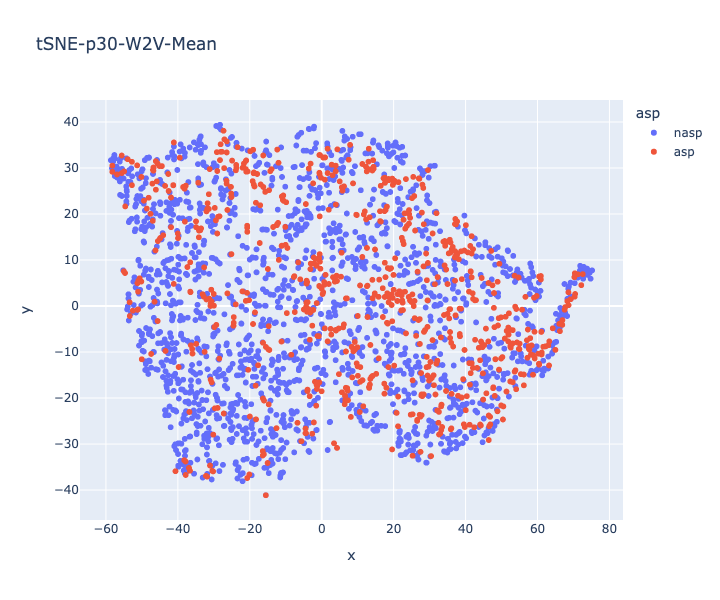

In [9]:
plot_df = pd.DataFrame({"x": proj[:,0], "y": proj[:,1], 
                        "phone": phone_labels,
                        "asp": asp_labels})
fig = px.scatter(plot_df, "x", "y", color="asp", 
                 title="tSNE-p30-W2V-Mean",
                 hover_data=["phone"])
fig.update_layout(
    width=600, height=600)

## LDA

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Empirical LDA (W2V-First)

In [11]:
trainX, testX, trainY, testY = train_test_split(
                                w2v_first, asp_labels, test_size=.2,
                                stratify=asp_labels, 
                                random_state=SEED,
                                )

In [12]:
trainX.shape, trainY.shape

((2009, 1024), (2009,))

In [13]:
lda_first = LinearDiscriminantAnalysis()
lda_first.fit(trainX, trainY)
lda_first.score(trainX, trainY), lda_first.score(testX, testY)

(0.9815828770532603, 0.8449304174950298)

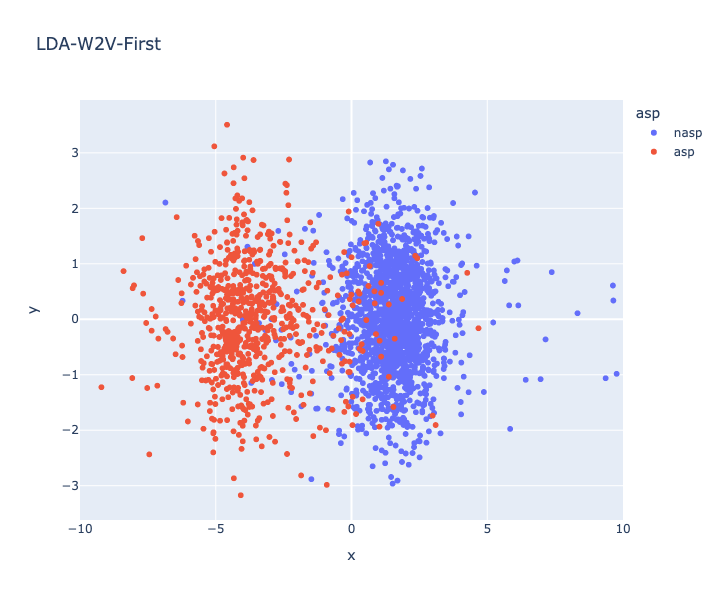

In [14]:
lda_proj = lda_first.transform(w2v_first)
plot_df = pd.DataFrame({"x": lda_proj[:,0], "y": np.random.randn(lda_proj.shape[0]), 
                        "phone": phone_labels,
                        "asp": asp_labels})
fig = px.scatter(plot_df, "x", "y", color="asp", 
                 hover_data=["phone"],
                 title="LDA-W2V-First")
fig.update_layout(
    width=600, height=600)
fig.update_xaxes(range=[-10,10])

In [15]:
del trainX, testX, trainY, testY

### Empirical LDA (W2V-Mean)

In [16]:
trainX, testX, trainY, testY = train_test_split(
                                w2v_mean, asp_labels, test_size=.2,
                                stratify=asp_labels,
                                random_state=SEED)

In [17]:
trainX.shape, trainY.shape

((2009, 1024), (2009,))

In [18]:
lda_mean = LinearDiscriminantAnalysis()
lda_mean.fit(trainX, trainY)
lda_mean.score(trainX, trainY), lda_mean.score(testX, testY)

(0.9885515181682429, 0.9025844930417495)

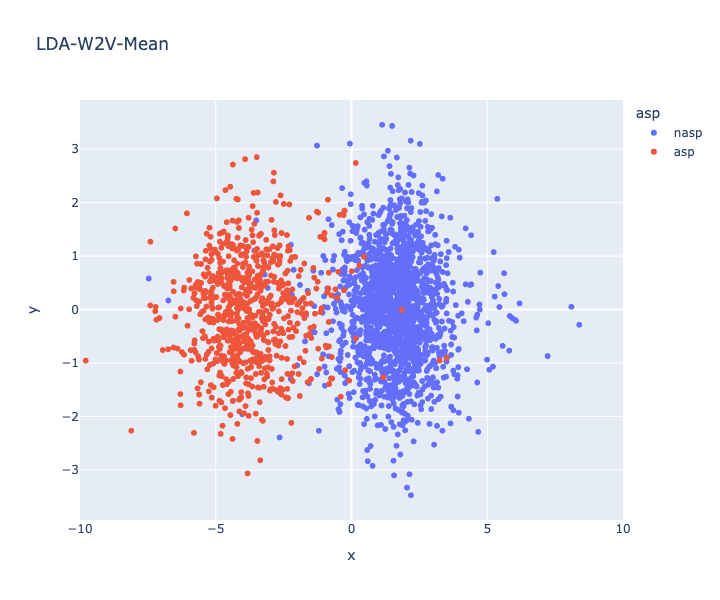

In [19]:
lda_proj = lda_mean.transform(w2v_mean)
plot_df = pd.DataFrame({"x": lda_proj[:,0], "y": np.random.randn(lda_proj.shape[0]), 
                        "phone": phone_labels,
                        "asp": asp_labels})
fig = px.scatter(plot_df, "x", "y", color="asp", 
                 title="LDA-W2V-Mean",
                 hover_data=["phone"])
fig.update_layout(
    width=600, height=600)
fig.update_xaxes(range=[-10,10])

In [20]:
del trainX, testX, trainY, testY

### Permuted LDA

In [21]:
rng = np.random.RandomState(123)
perm_asp_labels = asp_labels.sample(frac=1., replace=False)
trainX, testX, trainY, testY = train_test_split(
                                w2v_mean, perm_asp_labels, test_size=.2,
                                stratify=perm_asp_labels,
                                random_state=SEED)

In [22]:
trainX.shape, trainY.shape

((2009, 1024), (2009,))

In [23]:
lda_perm = LinearDiscriminantAnalysis()
lda_perm.fit(trainX, trainY)
lda_perm.score(trainX, trainY), lda_perm.score(testX, testY)

(0.8770532603285216, 0.5407554671968191)

In [24]:
del trainX, testX, trainY, testY

### Majority Baseline

In [25]:
from sklearn.dummy import DummyClassifier
trainX, testX, trainY, testY = train_test_split(
                                w2v_mean, asp_labels, test_size=.2,
                                stratify=asp_labels,
                                random_state=SEED)
majority = DummyClassifier(strategy="most_frequent")
majority.fit(trainX, trainY)
majority.score(trainX, trainY), majority.score(testX, testY)

(0.701841712294674, 0.7017892644135189)

In [26]:
del trainX, testX, trainY, testY

## Subset data

In [27]:
df_sub = df.loc[df.phone.isin(["t", "d"]), :]
tsne = TSNE(perplexity=30)
proj = tsne.fit_transform(np.vstack(df_sub.w2v_mean))

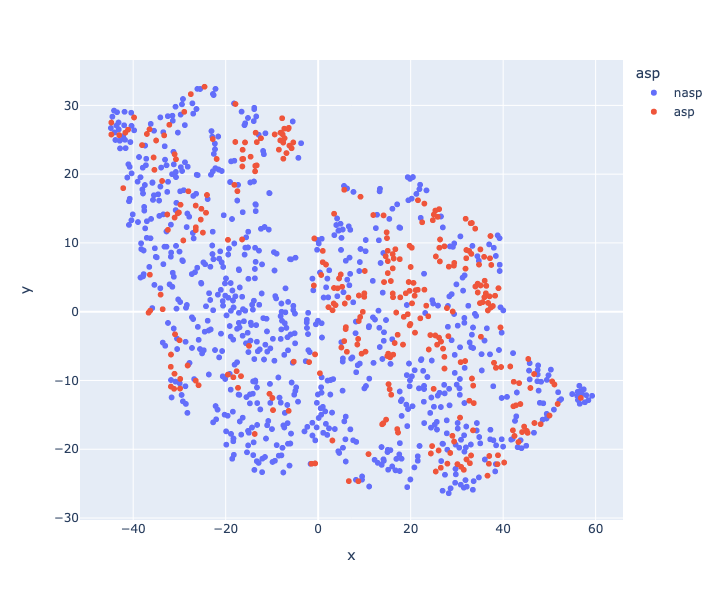

In [28]:
plot_df = pd.DataFrame({"x": proj[:,0], "y": proj[:,1], 
                        "phone": df_sub.phone,
                        "asp": df_sub.type})
fig = px.scatter(plot_df, "x", "y", color="asp", hover_data=["phone"])
fig.update_layout(
    width=600, height=600)